### IMPORTS AND LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import nltk
import re
import string
import contractions
import inflect
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


### NLTK RESOURCES

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wired\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wired\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wired\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
# Estructura del CSV esperada:
# ┌──────────────┬───────────────────────────────────────────────────────────────────────────┬────────────┐
# │   id         │                                text                                       │  label     │
# └──────────────┴───────────────────────────────────────────────────────────────────────────┴────────────┘
# label: (opcional para evaluación) - valores posibles: "izquierda", "centro", "derecha"

df = pd.read_csv(r"C:\Users\wired\OneDrive\Documentos\SEXTO SEMESTRE\PMC\VerBias\noticias.csv", sep=";")  # cambia esto según tu ruta
df = df.dropna(subset=['text'])  # asegúrate de no tener textos vacíos

print(df.head())
print(df.columns)

   id                                               text      label
0   1  The government announced new social reforms to...  izquierda
1   2  A call for reduced taxes on large corporations...    derecha
2   3  Analysts suggest a balanced approach is needed...     centro
3   4  Protesters demand stronger environmental prote...  izquierda
4   5  The economic growth was attributed to deregula...    derecha
Index(['id', 'text', 'label'], dtype='object')


### PREPROCESAMIENTO DE TEXTO

In [15]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
inflect_engine = inflect.engine()

def preprocess_text(text):
    # Expandir contracciones
    text = contractions.fix(text)
    
    # Lowercase y eliminar puntuación
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)

    # Tokenizar
    tokens = nltk.word_tokenize(text)

    # Eliminar stopwords y lematizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]
    
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)


### VECTORIZACION

In [16]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['clean_text'])


### K - MEANS

In [17]:
k = 3  # para izquierda, centro, derecha
model = KMeans(n_clusters=k, random_state=42)
df['cluster'] = model.fit_predict(X)

print(df[['text', 'cluster']].head())


                                                text  cluster
0  The government announced new social reforms to...        2
1  A call for reduced taxes on large corporations...        1
2  Analysts suggest a balanced approach is needed...        1
3  Protesters demand stronger environmental prote...        0
4  The economic growth was attributed to deregula...        1


#### EVALUACION

In [18]:
score = silhouette_score(X, df['cluster'])
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.008


#### VISUALIZACION

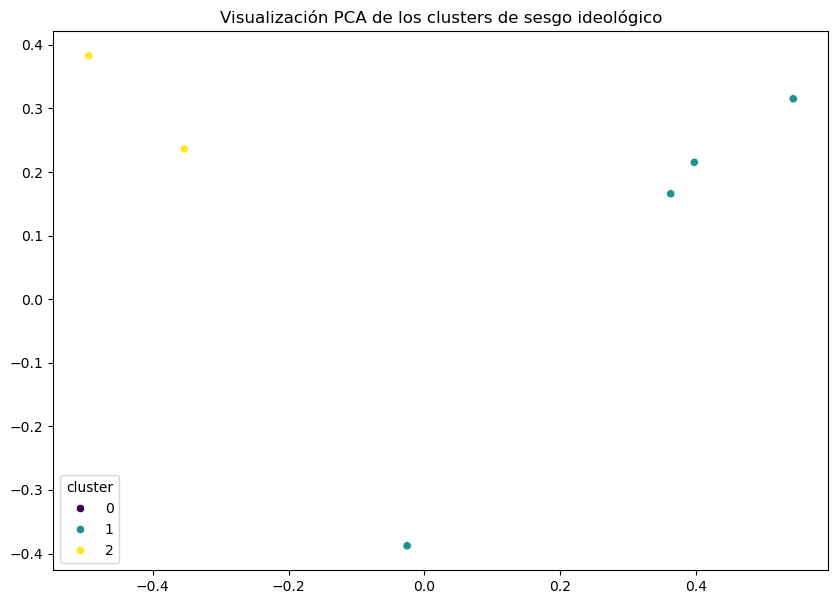

In [19]:
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=df['cluster'], palette="viridis")
plt.title("Visualización PCA de los clusters de sesgo ideológico")
plt.show()


#### KEY - WORDS

In [20]:
def top_terms_per_cluster(tfidf, labels, vectorizer, n=10):
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    
    for i in range(k):
        print(f"Cluster {i}:")
        print(", ".join([terms[ind] for ind in order_centroids[i, :n]]))
        print()

top_terms_per_cluster(X, df['cluster'], vectorizer)


Cluster 0:
labor, protection labor, environmental protection, environmental, stronger, stronger environmental, protester, protester demand, protection, labor right

Cluster 1:
economic, policy, deregulation, freedom, economic growth, deregulation market, growth, growth attributed, attributed deregulation, attributed

Cluster 2:
reform, government, official, official promote, expert, expert urge, promote, promote foreign, foreign, investment less



In [21]:
# Mapea manualmente los clusters a ideologías
cluster_map = {
    0: "derecha",    # <- ajusta esto según tu análisis
    1: "centro",
    2: "izquierda"
}

df['ideologia'] = df['cluster'].map(cluster_map)


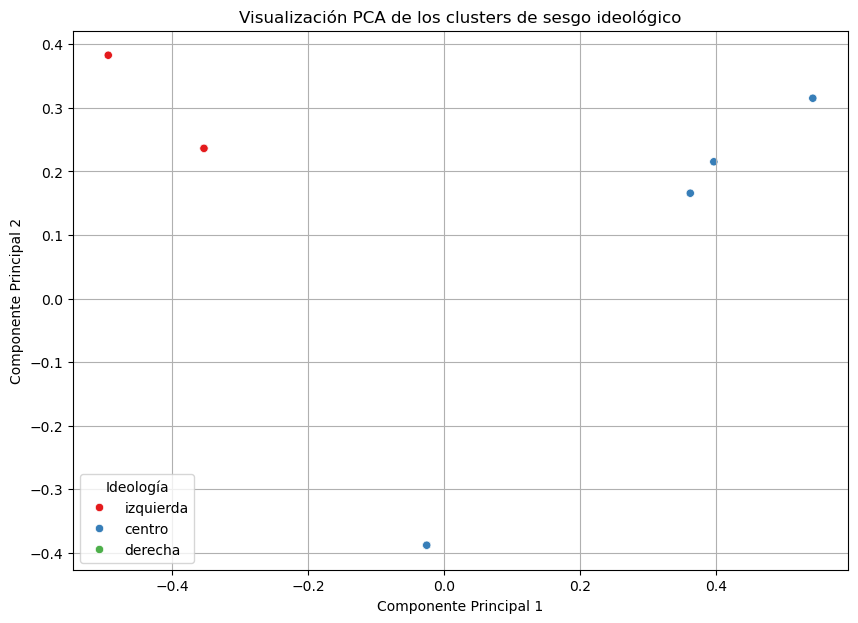

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=components[:, 0], 
    y=components[:, 1], 
    hue=df['ideologia'],  # usamos las etiquetas
    palette="Set1"
)
plt.title("Visualización PCA de los clusters de sesgo ideológico")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Ideología")
plt.grid(True)
plt.show()
